In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap 
from tqdm import trange
import copy

from celluloid import Camera
from IPython.display import Image
from IPython.core.display import display, HTML

In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
plt.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\ffmpeg\bin\ffmpeg.exe'
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

# Agent Based Modelling - assignment list 1

In [4]:
def generate_forest(size, probability):
    """
    Generates a matrix representing a forest, where: 
        empty cell is represented by 0
        occupied by a tree is represented by 1
        burning tree is represented by 2
        
    Input:
        size: int - length of one side in square lattice
        probability: float - probability between [0,1], in which a cell is populated by a tree
        
    Output:
        matrix: numpy.array - numpy matrix representing a model of a forest
    """
    matrix = np.random.rand(size*size)
    matrix = np.where(matrix > probability, 0, 1)
    matrix = np.reshape(matrix, (size, size))
    matrix[-1, :] = np.where(matrix[-1, :] == 1, 2, 0)
    
    return matrix

In [5]:
def get_neighbours(matrix, x, y):
    """
    Finds neighbours of a given cell
    
    Input:
        matrix: numpy.array - numpy matrix representing a model of a forest
        x: int - row index for a given cell
        y: int - column index for a given cell
        
    Output:
        neighbours: list - list of states of neighbours
    """
    new_array = np.zeros(shape=(len(matrix)+2, len(matrix)+2), dtype=int)
    new_array[1:-1, 1:-1] = matrix  
    
    neighbours = []
    standard_neighbours = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
    for dx, dy in standard_neighbours:
        neighbours.append(new_array[x+1+dx][y+1+dy])
    
    return neighbours

In [6]:
def fire_simulation(matrix):
    """
    Simulation of a burning forest. Rules: A cell occupied by a tree becomes a burning cell, if any of its eight 
    neighbouring cells are burning. A burning cell turns into an burnt tree and it is represented by 3 in the matrix. 
    
    Input:
        matrix: numpy.array - matrix representing a model of a forest
        
    Output:
        states: list - list of numpy.array objects representing all steps of burning forest
        hit_opposite_edge: bool - returns True if there is a burnt tree in the top row at the end of a simulation, False otherwise
    """
    states = [matrix]
    next_step = np.array(matrix, copy=True)
    hit_opposite_edge = False
    while np.any(matrix[:, :] == 2):  # until there is at least one burning cell
        if np.any(matrix[0, :] == 2):  # top row has burning cell
            hit_opposite_edge = True
        for i in range(L):
            for j in range(L):
                neighbours = get_neighbours(matrix, i, j)
                if matrix[i, j] == 2:  # burning cell turns into burnt tree
                    next_step[i, j] = 3
                elif 2 in neighbours and matrix[i, j] == 1:  # cell has neighbour, which is burning
                    next_step[i, j] = 2

        matrix = np.array(next_step, copy=True) 
        states.append(matrix)
        
        
    return states, hit_opposite_edge

In [7]:
def optimized_fire_simulation(matrix):
    """
    Simulation of a burning forest. Rules: A cell occupied by a tree becomes a burning cell, if any of its eight 
    neighbouring cells are burning. A burning cell turns into an burnt tree and it is represented by 3 in the matrix. 
    
    Input:
        matrix: numpy.array - matrix representing a model of a forest
        
    Output:
        states: list - list of numpy.array objects representing all steps of burning forest
        hit_opposite_edge: bool - returns True if there is burnt tree in the top row at the end of a simulation, False otherwise
    """
    new_array = np.zeros(shape=(len(matrix)+2, len(matrix)+2), dtype=int)
    new_array[1:-1, 1:-1] = matrix  
    matrix = np.array(new_array, copy=True)  
    
    states = [matrix]
    next_step = np.array(matrix, copy=True)
    hit_opposite_edge = False
    burning_trees = []
    neighbours = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
    for (row, col), value in np.ndenumerate(matrix):
        if value == 2:
            burning_trees.append((row, col))

    while len(burning_trees) > 0:
        if np.any(matrix[1, :] == 2):  # top row has burning cell
            hit_opposite_edge = True
        new_burning_trees = []
        for burning_tree in burning_trees:
            for neighbour in neighbours:
                neighbour_x_coord = burning_tree[0]+neighbour[0]
                neighbour_y_coord = burning_tree[1]+neighbour[1]
                if matrix[neighbour_x_coord, neighbour_y_coord] == 1:
                    next_step[neighbour_x_coord, neighbour_y_coord] == 2
                    if (neighbour_x_coord, neighbour_y_coord) not in new_burning_trees:
                        new_burning_trees.append((neighbour_x_coord, neighbour_y_coord))
                        next_step[neighbour_x_coord, neighbour_y_coord] = 2
                    
            next_step[burning_tree[0], burning_tree[1]] = 3
        matrix = np.array(next_step, copy=True)  
        states.append(matrix)
        burning_trees = new_burning_trees[:]  
        
    return states, hit_opposite_edge

In [8]:
def show_images(states):
    """
    Shows every step of a burning forest simulation

    Input:
        states: list - list of numpy.array objects representing all steps of burning forest
    """
    cmap = ListedColormap(['white', 'green', 'red', 'black'])
    plt.imshow(states[0], interpolation="nearest", cmap=ListedColormap(['white', 'green', 'red']))
    plt.show()
    for i in range(len(states)-1):
        plt.imshow(states[i+1], interpolation="nearest", cmap=cmap)
        plt.show()

In [9]:
def create_frames(states, L, p):
    """
    Creates an animation of a burning forest
    
    Input:
        states: list - list of numpy.array objects representing all steps of burning forest
        L: int - length of one side of a square lattice
        p: float - probability between [0,1], in which a cell is populated by a tree
        
    Output:
        animation: plt.animation - captured images to generate a gif file
    """
    cmap = ListedColormap(['white', 'green', 'red', 'black'])
    images = []
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.gca()
    camera = Camera(fig)
    
    plt.imshow(states[0], interpolation="nearest", cmap=ListedColormap(['white', 'green', 'red']))
    ax.text(0.21, 1.01, "step %s for p = %s" % (1, p), size=20, transform=ax.transAxes)
    camera.snap()
    for i in range(len(states)-1):
        ax.text(0.21, 1.01, "step %s for p = %s" % (str(i+1), p), size=20, transform=ax.transAxes)
        plt.imshow(states[i+1], interpolation="nearest", cmap=cmap)          
        camera.snap()
    
    animation = camera.animate()
    
    return animation 

In [10]:
def percolation_threshold(L, ps, mc):
    """
    Computes probabilities of forest fire hitting the opposite edge for different probabilities of populating a cell with a tree
    
    Input:
        L: int - length of one side in square lattice
        ps: list - list of probabilities of populating a cell with a tree
        mc: int - number of Monte Carlo simulations
        
    Output:
        probabilities: list - list of percolation threshold for different probabilities
        x_threshold: float - x coordinate of p* (percolation threshold)
        y_threshold: float - y coordinate of p* (percolation threshold)
    """
    probabilities = []
    for i in trange(len(ps)):
        probability = 0
        for j in range(mc):
            matrix = generate_forest(L, ps[i])
            _, hit_opposite_edge = optimized_fire_simulation(matrix)
            if hit_opposite_edge == True:
                probability += 1
        probabilities.append(probability/100)
        
    x_threshold, y_threshold = compute_percolation_threshold(probabilities, ps)
    
    return probabilities, x_threshold, y_threshold

In [11]:
def compute_percolation_threshold(probabilities, ps):
    """
    Computes coordinates (x, y) of a percolation point
    
    Input:
        probabilities: list - list of percolation thresholds for different probabilities
        ps: list - list of probabilities of populating a cell with a tree
        
    Output:
        x_threshold: float - x coordinate of p* (percolation threshold)
        y_threshold: float - y coordinate of p* (percolation threshold)
    """
    increments = list(np.diff(probabilities))
    max_increment = max(increments)
    increments_index = increments.index(max_increment)
    
    x_threshold = ps[increments_index]/2 + ps[increments_index+1]/2
    y_threshold = probabilities[increments_index]/2 + probabilities[increments_index+1]/2
    
    return x_threshold, y_threshold
    

In [12]:
def plot_percolation_threshold(probabilities, ps, x_threshold, y_threshold, L):
    """
    Plots probability of fire hitting the opposite edge for different probabilities of populating a cell with a tree and marks percolation threshold p*
    
    Input:
        probabilities: list - list of percolation threshold for different probabilities
        ps: list - list of probabilities of populating a tree
        x_threshold: float - percolation threshold coordinate x of p*
        y_threshold: float - percolation threshold coordinate y of p*    
    """
    plt.figure(figsize=(16, 9))
    plt.plot(ps, probabilities, '.', markersize=20, label='probability')
    plt.plot(x_threshold, y_threshold, '*', markersize=20, label='percolation threshold')
    plt.xlabel('Probability of planting trees', fontsize=20)
    plt.ylabel('Probability of hitting an opposite edge', fontsize=20)
    plt.title('Percolation threshold p* = %s for L = %s'% (round(x_threshold, 2), L), fontsize=24)
    plt.legend(prop = {'size': 24})
    plt.grid()

In [13]:
def hk_find(x, label_list):
    """
    Auxiliary function to the Hoshen–Kopelman algorithm. Finds a representative member of the cluster with which the current cell will be labeled.
    """
    y = x
    label_list = label_list
    while label_list[y] != y:
        y = label_list[y]
    while label_list[x] != x:
        z = label_list[x]
        label_list[x] = y
        x = z
    return y, label_list

In [14]:
def hk_union(x, y, label_list):
    """
    Auxiliary function to the Hoshen–Kopelman algorithm. Specifies that neighboring cells belong to the same cluster.
    """
    label_list[hk_find(x, label_list)[0]] = hk_find(y, label_list)[0]
    return label_list

In [15]:
def hk_forest_clustering(matrix, plots=False):
    """
    Hoshen–Kopelman algorithm for labeling clusters on a regular grid of cells, with the cells being either occupied or unoccupied.
    https://en.wikipedia.org/wiki/Hoshen%E2%80%93Kopelman_algorithm
    
    Input:
        matrix: np.array - matrix representing the last step of a forest fire
        plots: bool - if True, function additionally shows 4 plots:
               state of forest after the forest fire
               burnt trees only
               individual clusters after the clustering
               the biggest cluster
    Output:
        clustered_forest: np.array - matrix in which each number represents cell affiliation to a specific cluster
    """
    L = len(matrix)
    burnt_trees = np.where(matrix == 3, 1, 0)
    largest_label = 0
    label = np.zeros(matrix.shape, dtype=int)
    label_list = [i for i in range(L*L)]
    for i in range(L):
        for j in range(L):
            if burnt_trees[i,j]:
                left = label[i,j-1] if j-1 >= 0 else 0
                above = label[i-1,j] if i-1 >= 0 else 0
                if left == 0 and above == 0:
                    largest_label += 1
                    label[i,j] = largest_label
                elif left != 0 and above == 0:
                    label[i,j], label_list = hk_find(left, label_list)
                elif left == 0 and above != 0:
                    label[i,j], label_list = hk_find(above, label_list)
                else:
                    label_list = hk_union(left, above, label_list)
                    label[i,j], label_list = hk_find(left, label_list)

    clustered_forest = np.zeros(matrix.shape, dtype=int)
    for i in range(L):
        for j in range(L):
            current_label = label[i,j]
            while current_label != label_list[current_label]:
                current_label = label_list[current_label]
            clustered_forest[i,j] = label_list[current_label]
    
    if plots and np.any(clustered_forest):       
        plt.figure(figsize=(16,16))
        plt.subplot(2,2,1)
        plt.title('Simulation finished', fontsize=20)
        plt.imshow(matrix, interpolation="nearest", cmap=ListedColormap(['white', 'green', 'black']))
        plt.subplot(2,2,2)
        plt.title('Removing all burnt trees', fontsize=20)
        plt.imshow(np.where(matrix == 3, 1, 0), interpolation="nearest", cmap=ListedColormap(['white', 'black']))
        plt.subplot(2,2,3)
        plt.title('Forest clustering', fontsize=20)
        cmap = copy.copy(cm.get_cmap('nipy_spectral'))
        cmap.set_under('white')
        plt.imshow(clustered_forest, interpolation="nearest", cmap=cmap)
        plt.gca().get_images()[0].set_clim(0.5, None)
        plt.subplot(2,2,4)
        hk_biggest_cluster_size(clustered_forest, True)
    elif plots:
        print('There are no burnt trees')
        
    return clustered_forest

In [16]:
def hk_biggest_cluster_size(matrix, plots=False):
    """
    Finds the size of the biggest cluster
    
    Input:
        matrix: np.array - matrix in which each number represents cell affiliation to a specific cluster

    Output:
        biggest_cluster_size: int - size of the biggest cluster
    """
    if np.any(matrix):
        size_counts = np.bincount(matrix.flat[:])[1:]
        biggest_cluster_label = np.bincount(matrix.flat[:])[1:].argmax()
        biggest_cluster_size = size_counts[biggest_cluster_label]

        if plots:
            plt.title('The biggest cluster of burnt trees in forest', fontsize=20)
            plt.imshow((np.where(matrix == biggest_cluster_label+1, 1, 0) + np.where(matrix > 0, 1, 0)),
                       interpolation="nearest", cmap=ListedColormap(['white', 'grey', 'blue']))
    
    else:
        biggest_cluster_size = 0
    
    return biggest_cluster_size

In [17]:
def visualization_of_spreading_fire(L, p):
    """
    Captures images to generate a GIF of a forest fire spread
    
    Input:
        L: int - length of one side of a square lattice
        p: float - probability between [0,1], in which a cell is populated by a tree
        
    Output:
        animation: plt.animation - captured images to generate a gif file
    """
    matrix = generate_forest(L, p)
    states, hit_opposite_edge = optimized_fire_simulation(matrix)
    animation = create_frames(states, L, p)
    plt.close()

    return animation

## Visualization of forest fire spreading for L = 20

In [18]:
L = 20
p = 0.64

In [19]:
animation = visualization_of_spreading_fire(L, p)
HTML(animation.to_html5_video())

## Visualization of forest fire spreading for L = 50

In [20]:
L = 50
p = 0.48

In [21]:
animation = visualization_of_spreading_fire(L, p)
HTML(animation.to_html5_video())

## Visualization of forest fire spreading for L = 100

In [22]:
L = 100
p = 0.44

In [23]:
animation = visualization_of_spreading_fire(L, p)
HTML(animation.to_html5_video())

## Computing of percolation thresholds p*

In [24]:
Ls = [20, 50, 100]
ps = np.linspace(0, 1, 101)
mc = 100

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:22<00:00,  4.44it/s]


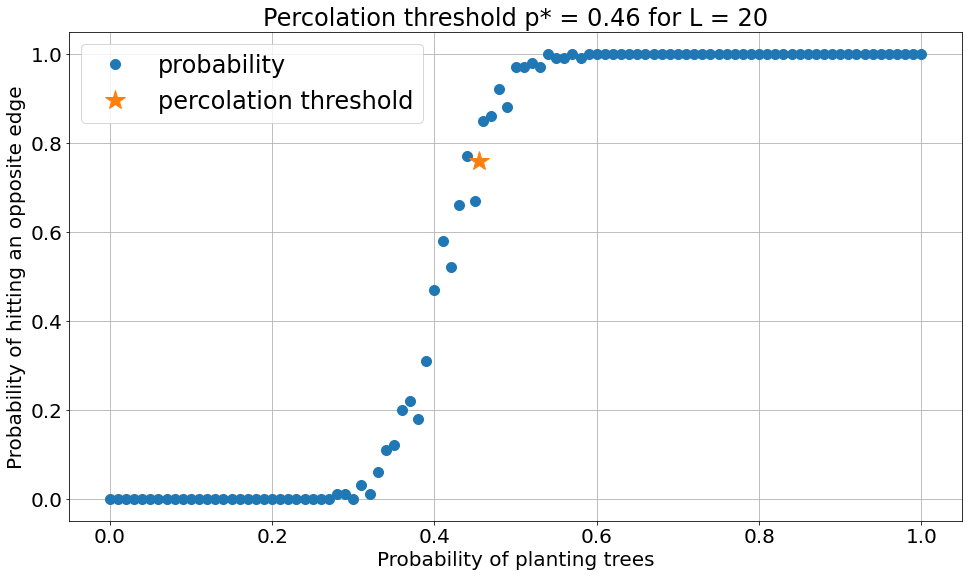

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it]


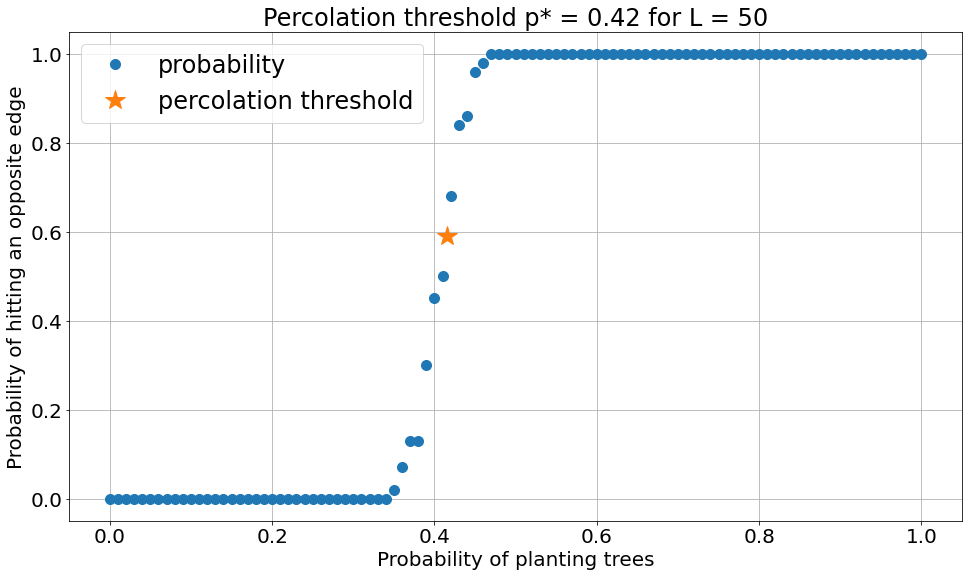

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [11:49<00:00,  7.02s/it]


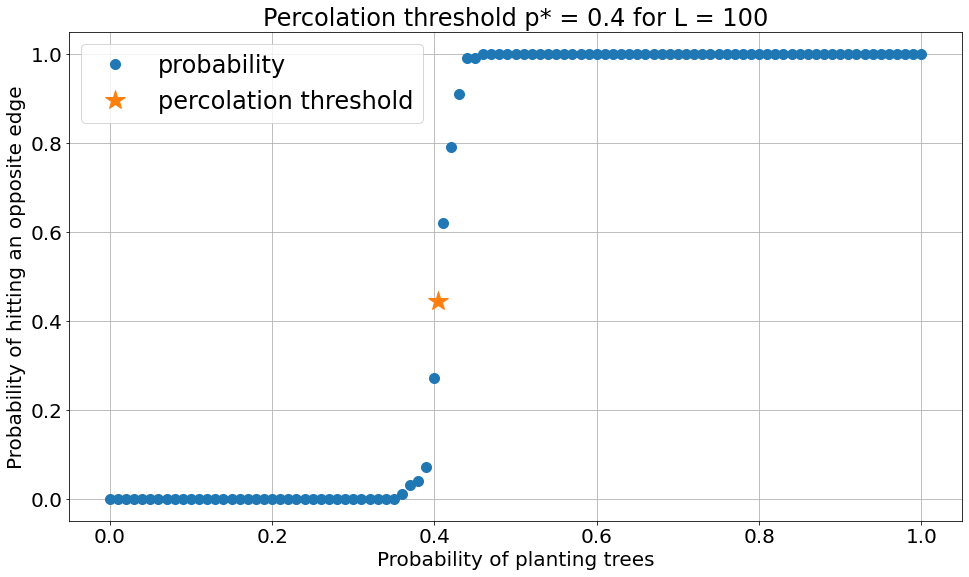

In [25]:
for L in Ls:
    probabilities, x_threshold, y_threshold = percolation_threshold(L, ps, mc)
    plot_percolation_threshold(probabilities, ps, x_threshold, y_threshold, L)
    plt.show()

## Finding the biggest cluster

In [26]:
L = 100
p = 0.45

matrix = generate_forest(L, p)
states, hit_opposite_edge = optimized_fire_simulation(matrix)

104


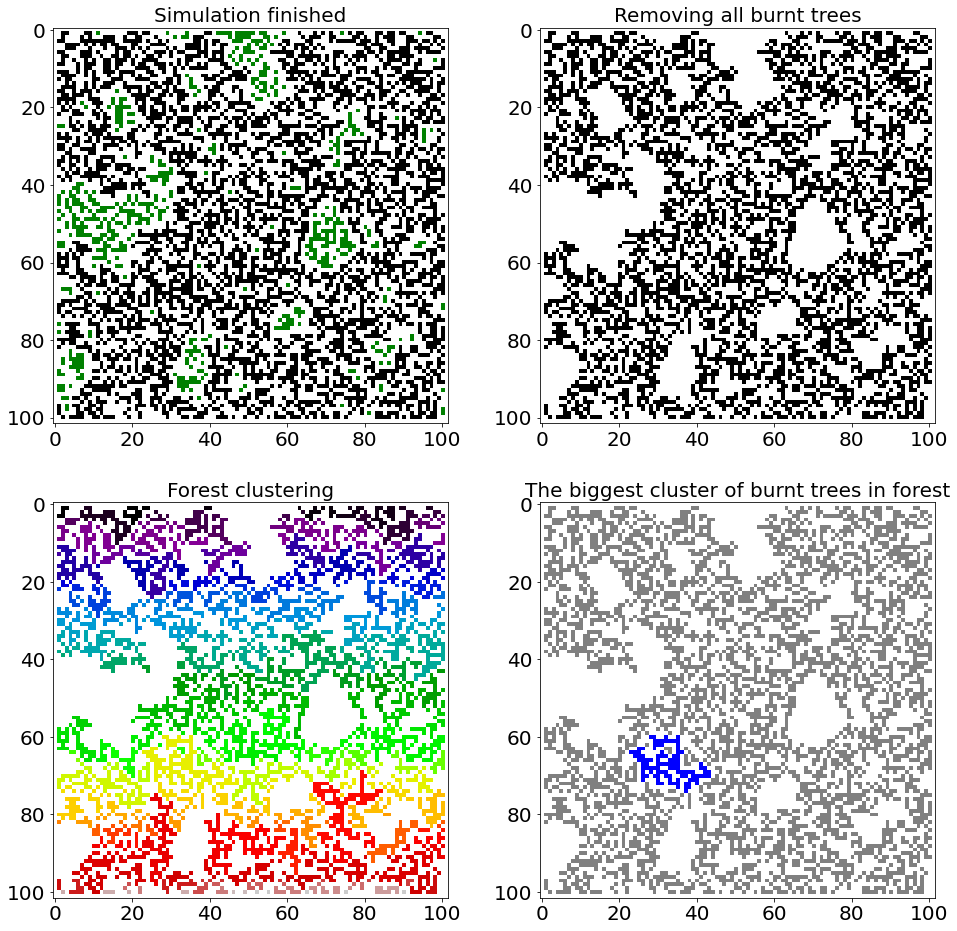

In [27]:
clusters = hk_forest_clustering(states[-1], True)
print(hk_biggest_cluster_size(clusters))

## Average size of the biggest cluster of burned trees as a function of p for L = 100

In [28]:
def computing_biggest_clusters(L, ps, mc):
    """
    Computes an average size of the biggest cluster of burnt trees after finishing simulation
    
    Input:
        L: int - length of one side of a square lattice
        ps: list - list of probabilities of populating a tree
        mc: int - number of Monte Carlo simulations
        
    Output:
        values_cluster: list - list of average size of the biggest cluster for different probability 
    """
    values_cluster = []
    for p in trange(len(ps)):
        value_cluster = []
        for i in range(mc):
            matrix = generate_forest(L, ps[p])
            states, hit_opposite_edge = optimized_fire_simulation(matrix)
            clusters = hk_forest_clustering(states[-1], False)
            value_cluster.append(hk_biggest_cluster_size(clusters, False))

        values_cluster.append(sum(value_cluster)/len(value_cluster)) 
        
    return values_cluster

In [29]:
def plot_average_size_of_biggest_cluster(values_cluster, L, ps):
    """
    Plots average size of the biggest cluster of burnt trees after finishing simulation
    
    Input:
        values_cluster: list - list of average size of the biggest cluster for different probability 
        L: int - length of one side of a square lattice
        ps: list - list of probabilities of populating a tree  
    """
    plt.figure(figsize=(16, 9))
    plt.plot(ps, values_cluster, '.', markersize=20)
    plt.xlabel('Probability of planting trees', fontsize=24)
    plt.ylabel('Average size of the biggest cluster', fontsize=24)
    plt.title('Average size of the biggest cluster for L='+str(L), fontsize=30)
    plt.legend(['Size of the biggest cluster'], prop={'size': 24})
    plt.grid()

In [30]:
ps = np.linspace(0, 1, 101)
L = 100
mc = 100

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [16:31<00:00,  9.82s/it]


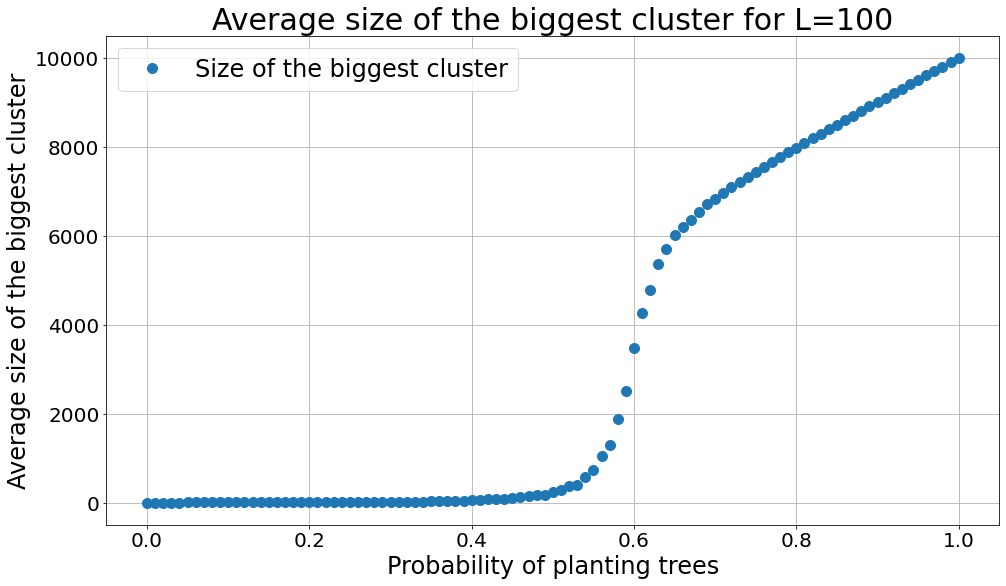

In [31]:
values_cluster = computing_biggest_clusters(L, ps, mc)
plot_average_size_of_biggest_cluster(values_cluster, L, ps)

# Optional: forest fire spread simulation with wind

Wind simulation: fire still can move only between neighbouring cells, but it has lower probability of spreading against the wind.

In [32]:
def angle_diff(wind_angle, neighbour):
    """
    Computes a difference between wind direction and neighbouring cell
    
    Input:
        wind_angle: float - wind angle in degrees [0,360)
        neighbour: tuple - direction from a given cell to its neighbour, e.g. (-1, 0) for the neighbour on the left side
        
    Output:
        difference between wind direction and neighbour direction
    
    """
    neighbour_angle = (np.arctan2(-neighbour[0], neighbour[1]) * 180/np.pi) % 360
    return abs(((((wind_angle - neighbour_angle) % 360) + 540) % 360) - 180)

In [33]:
def windy_fire_simulation(matrix, wind_force = 0, wind_angle = 0):
    """
    Simulation of burning forest. Rules: A cell occupied by a tree becomes a burning cell, if any of its eight 
    neighboring cells are burning. A burning cell turns into an burnt tree and it is represented by 3 in matrix. 
    
    Input:
        matrix: numpy.array - model of forest as numpy matrix     
        wind_force: float - strength of wind as float from the interval [0, 1]
        wind_angle: float - wind angle in degrees [0,360)
    Output:
        states: list - list of numpy.array objects representing all steps of burning forest
    """   
    
    new_array = np.zeros(shape=(len(matrix)+2, len(matrix)+2), dtype=int)
    new_array[1:-1, 1:-1] = matrix  
    matrix = np.array(new_array, copy=True)  
    
    states = [matrix]
    next_step = np.array(matrix, copy=True)
    hit_opposite_edge = False
    burning_trees = []
    neighbours = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
    for (row, col), value in np.ndenumerate(matrix):
        if value == 2:
            burning_trees.append((row, col))

    while len(burning_trees) > 0:
        if np.any(matrix[1, :] == 2):  # top row has burning cell
            hit_opposite_edge = True
        new_burning_trees = []
        for burning_tree in burning_trees:
            for neighbour in neighbours:
                x = np.random.random()
                neighbour_x_coord = burning_tree[0]+neighbour[0]
                neighbour_y_coord = burning_tree[1]+neighbour[1]
                if x < wind_force * np.cos(angle_diff(wind_angle, neighbour)*np.pi/180) + 1:
                    if matrix[neighbour_x_coord, neighbour_y_coord] == 1:
                        next_step[neighbour_x_coord, neighbour_y_coord] == 2
                        if (neighbour_x_coord, neighbour_y_coord) not in new_burning_trees:
                            new_burning_trees.append((neighbour_x_coord, neighbour_y_coord))
                            next_step[neighbour_x_coord, neighbour_y_coord] = 2
                    
            next_step[burning_tree[0], burning_tree[1]] = 3
        matrix = np.array(next_step, copy=True)  
        states.append(matrix)
        burning_trees = new_burning_trees[:]  
        
    return states, hit_opposite_edge

## Visualization of fire spreading with optional wind with one burning tree at the center of matrix

In [34]:
def wind_visualisation_subplot(L, p):
    """
    Presents results of fire spread simulations with wind in 8 different directions
    
    Input:  
        L: int - length of one side in square lattice
        p: float - probability between [0,1], in which a cell is populated by a tree  
    """
    matrix = generate_forest(L, p)
    matrix = np.where(matrix > 0, 1, 0)
    matrix[L//2, L//2] = 2
    directions = [135,90,45,180,0,0,225,270,315]
    descriptions = ['NW', 'N', 'NE', 'W', 'no', 'E', 'WS', 'S', 'SE']
    plt.figure(figsize=(12,12))
    for i in range(len(directions)):
        if i == 4:
            states, hit_opposite_edge = windy_fire_simulation(matrix, 0, directions[i])
        else:
            states, hit_opposite_edge = windy_fire_simulation(matrix, 0.7, directions[i])
        plt.subplot(3,3,i+1)
        plt.title('Wind:' + descriptions[i])
        plt.imshow(states[-1], interpolation="nearest", cmap=ListedColormap(['white', 'green', 'black']))

In [35]:
def wind_visualisation(L, p, matrix, wind_force, wind_angle):
    """ 
    Captures images to generate a GIF of a forest fire spread
       
    Input:
        L: int - length of one side in square lattice
        p: float - probability between [0,1], in which a cell is populated by a tree
        matrix: numpy.array - model of forest as numpy matrix 
        wind_force: float - strength of wind as float from the interval [0, 1]
        wind_angle: float - wind angle in degrees [0,360)
        
    Output:
        animation: plt.animation - captured images to generate a gif file
    """
    states, hit_opposite_edge = windy_fire_simulation(matrix, wind_force, wind_angle)
    animation = create_frames(states, L, p)
    plt.close()
    HTML(animation.to_html5_video())
    
    return animation

In [36]:
L = 100
p = 0.8
wind_force = 0.7
wind_angle = 90

matrix = generate_forest(L, p)
matrix = np.where(matrix > 0, 1, 0)
matrix[L//2, L//2] = 2

In [37]:
animation = wind_visualisation(L, p, matrix, wind_force, wind_angle)
HTML(animation.to_html5_video())

In [38]:
L = 100
p = 0.5

In [39]:
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

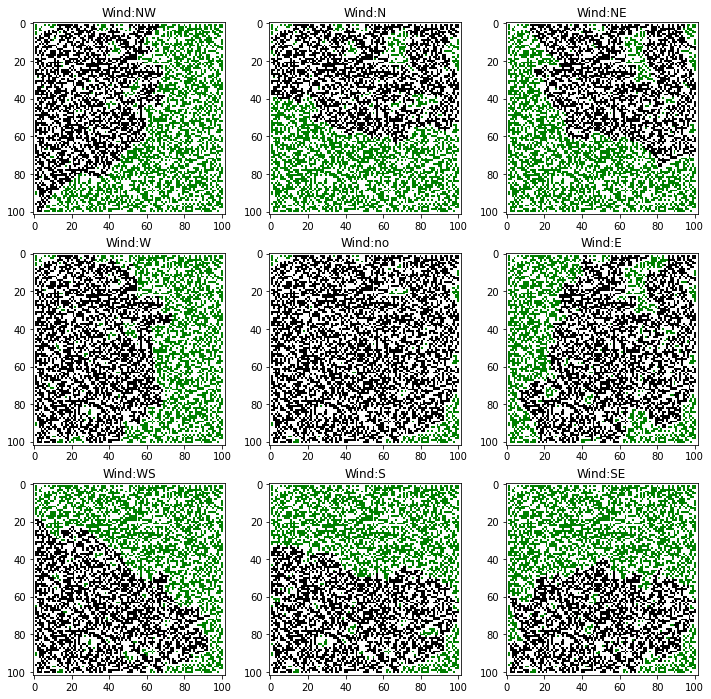

In [40]:
wind_visualisation_subplot(L, p)

## Functions to compute and plot percolation threshold for simulation with wind

In [41]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

In [42]:
def windy_percolation_threshold(L, ps, mc, wind_angle, wind_force):
    """
    Computes probabilities of forest fire hitting the opposite edge for different probabilities of populating a cell with a tree with optional wind
    
    Input:
        L: int - length of one side in square lattice
        ps: list - list of probabilities of populating a tree
        mc: int - number of Monte Carlo simulations
        wind_angle: float - wind angle in degrees [0,360)
        wind_force: float - strength of wind as float from the interval [0, 1]
        
    Output:
        probabilities: list - list of percolation threshold for different probabilities
        x_threshold: float - percolation threshold coordinate x of p*
        y_threshold: float - percolation threshold coordinate y of p*
    """
    probabilities = []
    for i in trange(len(ps)):
        probability = 0
        for j in range(mc):
            matrix = generate_forest(L, ps[i])
            _, hit_opposite_edge = windy_fire_simulation(matrix, wind_force, wind_angle)
            if hit_opposite_edge == True:
                probability += 1
        probabilities.append(probability/100)
        
    x_threshold, y_threshold = compute_percolation_threshold(probabilities, ps)
    
    return probabilities, x_threshold, y_threshold

In [43]:
def plot_windy_percolation_threshold(probabilities, ps, x_threshold, y_threshold, L):
    """
    Plots all values of probability that fire hit opposite edge and percolation threshold p*
    
    Input:
        probabilities: list - list of percolation threshold for different probabilities
        ps: list - list of probabilities of populating a tree
        x_threshold: float - percolation threshold coordinate x of p*
        y_threshold: float - percolation threshold coordinate y of p*
        L: int - length of one side in square lattice
    """
    plt.figure(figsize=(16, 9))
    plt.plot(ps, probabilities, '.', markersize=20, label='probability')
    plt.plot(x_threshold, y_threshold, '*', markersize=20, label='percolation threshold')
    plt.xlabel('Probability of planting trees', fontsize=20)
    plt.ylabel('Probability of hitting an opposite edge', fontsize=20)
    plt.title('Percolation threshold p* = %s for L = %s'% (round(x_threshold, 2), L), fontsize=24)
    plt.legend(prop = {'size': 24})
    plt.grid()

## Spreading of fire with optional wind - fire goes with the wind

### Visualization

In [44]:
L = 100
p = 0.50
wind_force = 0.7
wind_angle = 90

matrix = generate_forest(L, p)

In [45]:
animation = wind_visualisation(L, p, matrix, wind_force, wind_angle)
HTML(animation.to_html5_video())

### Computation of percolation threshold for simulation with wind (the same direction)

In [46]:
L = 50
ps = np.linspace(0, 1, 101)
mc = 100
wind_angle = 90
wind_force = 0.7

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [19:01<00:00, 11.30s/it]


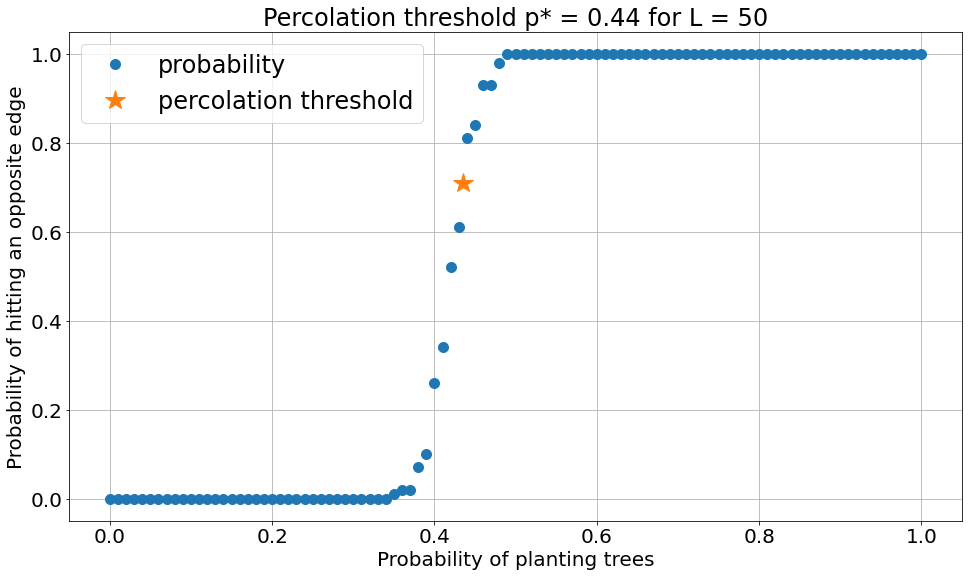

In [47]:
probabilities, x_threshold, y_threshold = windy_percolation_threshold(L, ps, mc, wind_angle, wind_force)
plot_windy_percolation_threshold(probabilities, ps, x_threshold, y_threshold, L)
plt.show()

## Spreading of fire with optional wind - fires goes against the wind

### Visualization for L=50 and strength = 0.5

In [48]:
L = 50
p = 0.53
wind_force = 0.5
wind_angle = 270

matrix = generate_forest(L, p)

In [49]:
animation = wind_visualisation(L, p, matrix, wind_force, wind_angle)
HTML(animation.to_html5_video())

### Visualization for L=50 and strength = 0.75

In [50]:
wind_force = 0.75
animation = wind_visualisation(L, p, matrix, wind_force, wind_angle)
HTML(animation.to_html5_video())

### Visualization for L=50 and strength = 1

In [51]:
wind_force = 1
animation = wind_visualisation(L, p, matrix, wind_force, wind_angle)
HTML(animation.to_html5_video())

### Computation of percolation threshold for simulation with against the wind

In [52]:
L = 50
ps = np.linspace(0, 1, 101)
mc = 100
wind_angle = 270
wind_force = 0.7
wind_forces = [0.5, 0.7, 1]

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [14:34<00:00,  8.66s/it]


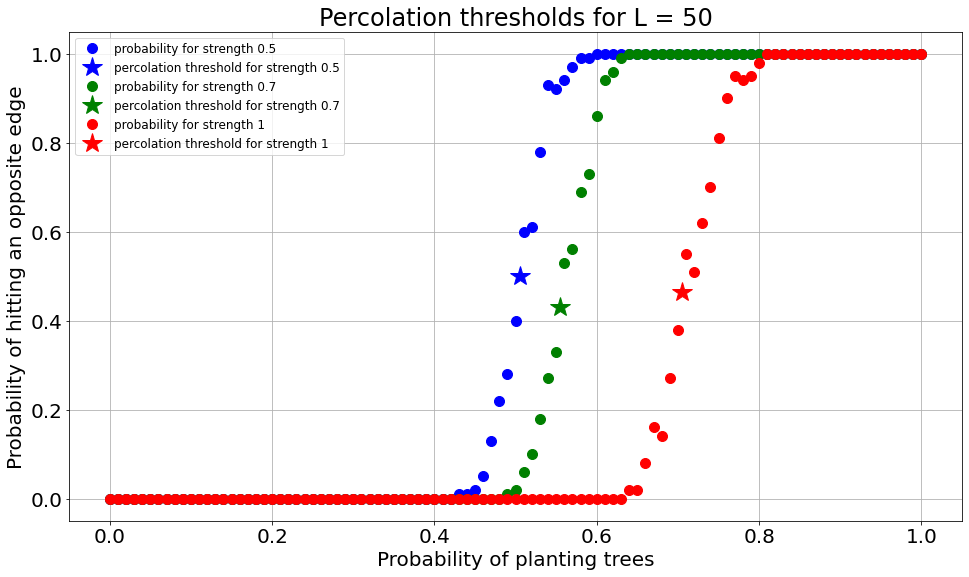

In [53]:
plt.figure(figsize=(16, 9))
plt.xlabel('Probability of planting trees', fontsize=20)
plt.ylabel('Probability of hitting an opposite edge', fontsize=20)
plt.title('Percolation thresholds for L = %s'% (L), fontsize=24)
plt.grid()
colors = ['blue', 'green', 'red']
for i in range(len(wind_forces)):
    probabilities, x_threshold, y_threshold = windy_percolation_threshold(L, ps, mc, wind_angle, wind_forces[i])    
    plt.plot(ps, probabilities, '.', color=colors[i], markersize=20, label='probability for strength ' + str(wind_forces[i]))
    plt.plot(x_threshold, y_threshold, '*', color=colors[i], markersize=20, label='percolation threshold for strength ' + str(wind_forces[i]))
    plt.legend(prop = {'size': 12})
    
plt.show()

# Conclusion

We've created a model of a forest on a lattice and then we've ignited a specific group of trees. Furthermore we've analyzed how the fire is spreading in forests of different densities. 

From our simulations we've learnt that width of a transition between 0 probability of hitting an opposite edge of a lattice and probability of 1 depends on the size of lattice. It is clearly visible that for lower L, we've obtained more values of probability of planting trees when probability of hitting an opposite edge is different than 0 and 1. For L=20 it is about (0.3 to 0.5). However, for L=100, this jump is almost immediate (values of probability of dense forest between 0.37 and 0.43).

In addition to that, from finding the biggest clusters of burned trees, we've observed that for low probability of populating a cell with a tree, it is difficult to find any larger clusters. For probabilities of about 0.5 to 0.65 however, it started growing rapidly. From this point on it behaves like linear function, the density of the forest is so high that almost every burned cell is connected to each other.

Lastly, the addition of wind to our model let us investigate how it changes the behaviour of the fire spread. Tweaking its strength and direction can heavily modify fire spreading process, e.g. a fire that tries to spread against the direction of a strong wind might have some difficulties and die out quickly.